#  MDOEL_LSTM 
- LSTM 모델 구축 -> 1996~2020 테스트 -> 과적합 확인
- prophet 모델로 미래 feature 생성 -> LSTM 모델로 2021~2035 가스수요 예측하기


# 1996~2020 데이터로 LSTM 구축 및 확인
---

In [335]:
# 모듈 로딩
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic')


## 1. 데이터 전처리
---

In [336]:
POWER_FIRE = pd.read_csv('../pred_POWER_FIRE.csv')
ELEC_ALL = pd.read_csv('../pred_ELEC_ALL.csv')

POWER_FIRE = POWER_FIRE['yhat']
ELEC_ALL = ELEC_ALL['yhat']

In [337]:
# 모델 학습할 데이터 
train_feature = pd.read_csv('../data_tomato.csv')
train_target = pd.read_csv('../target.csv')

In [338]:
# 자체 예측한 feature
future_feature = pd.read_csv('../data_future.csv')
future_feature = pd.concat([future_feature,POWER_FIRE,ELEC_ALL], axis=1)
future_feature.columns = ['DATE', 'POWER_GAS', 'ELEC_IND_SUM', 'OIL_PRICE', 'QVA', 'TCL_LT',
       'TEMP_EF', 'ELEC_SERVICE', 'POWER_FIRE', 'ELEC_ALL']
future_feature

,DATE,POWER_GAS,ELEC_IND_SUM,OIL_PRICE,QVA,TCL_LT,TEMP_EF,ELEC_SERVICE,POWER_FIRE,ELEC_ALL
0,2021-01-01,21004815,24009895,106.270957,122715.511387,-0.819359,3.720112,1.546123e+07,11984432,49065403
1,2021-02-01,19006411,22411095,106.452033,123791.588066,-0.488770,3.663880,1.485668e+07,10016106,46838260
2,2021-03-01,17216940,23047185,106.615613,123126.447539,0.108879,3.557796,1.291000e+07,11379175,43744720
3,2021-04-01,15290843,22640767,106.796638,123534.791822,0.929050,3.418933,1.228525e+07,9588955,42509561
4,2021-05-01,15763108,22310541,106.971887,123756.051487,1.691170,3.297840,1.092951e+07,8879315,40265856
...,...,...,...,...,...,...,...,...,...,...
175,2035-08-01,23623051,27327684,137.373064,144116.665066,3.940146,3.173664,1.651412e+07,14316637,60281687
176,2035-09-01,21558395,26481467,137.554127,145813.462779,2.922097,3.231943,1.524711e+07,12565225,57078253
177,2035-10-01,20954172,26795426,137.729350,145918.753203,1.620847,3.358512,1.358630e+07,13568001,54776519
178,2035-11-01,21861274,27345267,137.910414,146304.640846,0.430566,3.507064,1.477608e+07,15354540,56697266


In [339]:
train_target[['CIVIL','IND']]

,CIVIL,IND
0,605519,83809
1,566323,70427
2,477514,62652
3,337797,47050
4,184522,30709
...,...,...
295,398661,457970
296,380235,525619
297,616682,600890
298,1093747,665901


In [340]:
train_all =pd.concat([train_feature,train_target[['CIVIL','IND']]], axis =1)
train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATE                300 non-null    object 
 1   TCL_AT              300 non-null    float64
 2   TCL_LT              300 non-null    float64
 3   TCL_HT              300 non-null    float64
 4   TEMP_EF_CAP         300 non-null    float64
 5   TEMP_EF_DONGNAM     300 non-null    float64
 6   TEMP_EF_DAEGYUNG    300 non-null    float64
 7   TEMP_EF_CHOONG      300 non-null    float64
 8   TEMP_EF_HONAM       300 non-null    float64
 9   TEMP_EF_MEAN        300 non-null    float64
 10  POWER_WATER         300 non-null    int64  
 11  POWER_FIRE          300 non-null    int64  
 12  POWER_NUCLEAR       300 non-null    int64  
 13  POWER_NAEYEON       300 non-null    int64  
 14  POWER_GROUP         300 non-null    int64  
 15  POWER_TRANS         300 non-null    int64  
 16  POWER_GA

In [341]:
# 1996~2020
train_all = train_all[['DATE','POWER_GAS','ELEC_INDSUM','OIL_PRICE','QVA','TCL_LT'	,'TEMP_EF_MEAN','ELEC_SERVICE','POWER_FIRE','ELEC_ALL','CIVIL','IND']]

# 1996~2020 feature
train_data = train_all.drop(['DATE','CIVIL','IND'], axis =1)

# 1996~2020 target
train_target = train_all[['CIVIL','IND']]
train_target_C = train_all['CIVIL']
train_target_I = train_all['IND']

# 2021~2035
test_data = future_feature.drop(['DATE'], axis =1)
test_data.columns = ['POWER_GAS','ELEC_INDSUM','OIL_PRICE','QVA','TCL_LT','TEMP_EF_MEAN','ELEC_SERVICE','POWER_FIRE','ELEC_ALL']

# 1996~2035
feature_all = pd.concat([train_data,test_data])
feature_all = feature_all.reset_index(drop = True) 
feature_all

,POWER_GAS,ELEC_INDSUM,OIL_PRICE,QVA,TCL_LT,TEMP_EF_MEAN,ELEC_SERVICE,POWER_FIRE,ELEC_ALL
0,8408979,9236808,27.860000,36550.300000,-0.189311,3.744768,3.616542e+06,2119473,16224867
1,7593086,8465308,29.040000,36751.000000,-0.226982,3.732234,3.551611e+06,1875589,15363840
2,8306941,9677322,27.990000,36951.700000,-0.045631,3.621268,3.333225e+06,1923728,16094268
3,8299351,9650845,28.740000,37152.400000,0.029456,3.460496,3.430624e+06,1747174,16266027
4,8156027,9658045,29.180000,37365.733333,0.242892,3.305460,3.333483e+06,2092955,16028072
...,...,...,...,...,...,...,...,...,...
475,23623051,27327684,137.373064,144116.665066,3.940146,3.173664,1.651412e+07,14316637,60281687
476,21558395,26481467,137.554127,145813.462779,2.922097,3.231943,1.524711e+07,12565225,57078253
477,20954172,26795426,137.729350,145918.753203,1.620847,3.358512,1.358630e+07,13568001,54776519
478,21861274,27345267,137.910414,146304.640846,0.430566,3.507064,1.477608e+07,15354540,56697266


## 2. 스케일링 및 컬럼 설정
---

In [342]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler_target = MinMaxScaler()
scale_cols = ['POWER_GAS','ELEC_INDSUM','OIL_PRICE','QVA','TCL_LT','TEMP_EF_MEAN','POWER_FIRE','ELEC_ALL']

# scale_cols = ['POWER_GAS','ELEC_INDSUM','OIL_PRICE','QVA','TEMP_EF_MEAN','ELEC_SERVICE','POWER_FIRE','ELEC_ALL']

# 스케일링
train_data_scaled = scaler.fit_transform(train_data[scale_cols])
test_data_scaled = scaler.fit_transform(test_data[scale_cols])
feature_all_scaled = scaler.fit_transform(feature_all[scale_cols])

train_target_scaled = scaler_target.fit_transform(train_target)

# 데이터프레임으로 변환
train_data_scaled = pd.DataFrame(train_data_scaled)
test_data_scaled = pd.DataFrame(test_data_scaled)
feature_all_scaled = pd.DataFrame(feature_all_scaled)
train_target_scaled = pd.DataFrame(train_target_scaled)

# 데이터프레임 컬럼명 생성
train_data_scaled.columns = scale_cols
test_data_scaled.columns = scale_cols
feature_all_scaled.columns = scale_cols

train_target_scaled.columns = ['CIVIL','IND']
train_target_scaled_C = train_target_scaled['CIVIL']
train_target_scaled_I = train_target_scaled['IND']


In [343]:
# 1996~2035 feature
feature_all_scaled[288:]

,POWER_GAS,ELEC_INDSUM,OIL_PRICE,QVA,TCL_LT,TEMP_EF_MEAN,POWER_FIRE,ELEC_ALL
288,0.634826,0.757511,0.537019,0.798716,0.185489,0.741927,0.622095,0.657726
289,0.511885,0.703409,0.482267,0.765871,0.142801,0.709549,0.536762,0.618894
290,0.374792,0.737817,0.344569,0.733027,0.282907,0.557194,0.528997,0.584310
291,0.435028,0.674569,0.210856,0.700182,0.381237,0.455845,0.327413,0.533424
292,0.424232,0.619866,0.210036,0.726088,0.557465,0.260096,0.262294,0.487805
...,...,...,...,...,...,...,...,...
475,0.946996,0.956416,0.641966,0.980212,0.997474,0.064203,0.778813,0.954157
476,0.835970,0.913614,0.643028,0.995558,0.798084,0.149245,0.673465,0.886109
477,0.803478,0.929494,0.644055,0.996510,0.543227,0.333938,0.733782,0.837215
478,0.852257,0.957305,0.645116,1.000000,0.310105,0.550709,0.841243,0.878016


## 3-1. 모델 학습_민수용
---

### 3-1-1. 과거학습 단위 설정 (민수용) 

In [344]:
# 과거 데이터 학습 함수(target 존재시)
def make_dataset1(data, label, window_size=12):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size): # 데이터 개월 개수 - 학습할 과거개월수 
        feature_list.append(np.array(data.iloc[i:i+window_size])) # 시작 개월 ~ 12개월
        label_list.append(np.array(label.iloc[i+window_size])) # 12개월 후 타겟 데이터
    return np.array(feature_list), np.array(label_list)

# 과거 데이터 학습 함수(target 존재하지 않을 시)
# test용
def make_dataset2(data, label, window_size=12):
    test_list = []
    for i in range(len(data) - window_size): # 데이터 개월 개수 - 학습할 과거개월수 
        test_list.append(np.array(data.iloc[i:i+window_size])) # 시작 개월 ~ 12개월 # 12개월 후 타겟 데이터
    return np.array(test_list)

In [345]:
# train, val, test 범위 설정

TEST_SIZE = 54 # 테스트: 2015~2020(60개월) / 학습: 1996~2014(240개월)
WINDOW_SIZE = 18 # 학습시킬 과거 개월 단위(12개월)

# 학습 데이터 
x_train = train_data_scaled[:-TEST_SIZE] # 1996~2014
x_val = train_data_scaled[-TEST_SIZE:] # 2015~2020
x_test = test_data_scaled # 2021~2035(최종 목표)
x_test_final = feature_all_scaled[288:]

# target 민수용(스케일 적용)
y_train_C = train_target_scaled_C[:-TEST_SIZE] # 1996~2014
y_val_C = train_target_scaled_C[-TEST_SIZE:] # 2015~2020

# target 민수용(스케일 X)
y_train_C = train_target_C[:-TEST_SIZE] # 1996~2014
y_val_C = train_target_C[-TEST_SIZE:] # 2015~2020


In [346]:
x_train.shape, y_train_C.shape

((246, 8), (246,))

In [347]:
# train, valid, test 과거학습 단위 생성

# 과거 12개월-> 다음 1개월 예측( 1996~2014년 )

# 민수용 
x_train, y_train_C = make_dataset1(x_train, y_train_C, WINDOW_SIZE)
x_val, y_val_C = make_dataset1(x_val, y_val_C, WINDOW_SIZE)

# test용 (2021~2035년)
x_test = make_dataset2(x_test_final, WINDOW_SIZE)

In [348]:
print('[ 1996~2015 train/target 데이터 ]')
print(f'x_train.shape: {x_train.shape}, y_train_C.shape: {y_train_C.shape}') 
print()
print('[ 2016~2020 train/target 데이터 ]')
print(f'x_val.shape  : {x_val.shape},  y_train_C.shape: {y_val_C.shape}') 
print()
print('[ 2021~2035 train 데이터 ]')
print(f'x_test.shape : {x_test_final.shape}')
print() 

[ 1996~2015 train/target 데이터 ]
x_train.shape: (228, 18, 8), y_train_C.shape: (228,)

[ 2016~2020 train/target 데이터 ]
x_val.shape  : (36, 18, 8),  y_train_C.shape: (36,)

[ 2021~2035 train 데이터 ]
x_test.shape : (192, 8)



### 3-1-2. 모형 구축 (민수용) 

In [349]:
# create LSTM model
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model_C = Sequential()
model_C.add(LSTM(32, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='relu', 
                return_sequences=False)
            )
# model_C.add(LSTM(32))

model_C.add(Dense(1))

In [350]:
# LSTM model compile

model_C.compile(loss='mape', optimizer='adam')
#early_stop = EarlyStopping(monitor='val_loss', patience=5)

# import os
#model_path = 'model'
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model_C.fit(x_train, y_train_C, 
                                    epochs=150, 
                                    batch_size=16,
                                    validation_data=(x_val, y_val_C))
                                    #callbacks=[early_stop])

Epoch 1/150
15/15 [==============================] - 1s 14ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 2/150
15/15 [==============================] - 0s 5ms/step - loss: 100.0000 - val_loss: 99.9999
Epoch 3/150
15/15 [==============================] - 0s 5ms/step - loss: 99.9998 - val_loss: 99.9991
Epoch 4/150
15/15 [==============================] - 0s 5ms/step - loss: 99.9913 - val_loss: 99.8455
Epoch 5/150
15/15 [==============================] - 0s 5ms/step - loss: 99.3639 - val_loss: 94.2584
Epoch 6/150
15/15 [==============================] - 0s 5ms/step - loss: 75.7974 - val_loss: 74.2590
Epoch 7/150
15/15 [==============================] - 0s 5ms/step - loss: 63.4386 - val_loss: 51.6646
Epoch 8/150
15/15 [==============================] - 0s 5ms/step - loss: 55.5693 - val_loss: 45.6162
Epoch 9/150
15/15 [==============================] - 0s 5ms/step - loss: 50.5456 - val_loss: 42.9667
Epoch 10/150
15/15 [==============================] - 0s 5ms/step - loss: 46.3920 - val

### 3-1-3. (민수용) loss, val_loss 시각화 

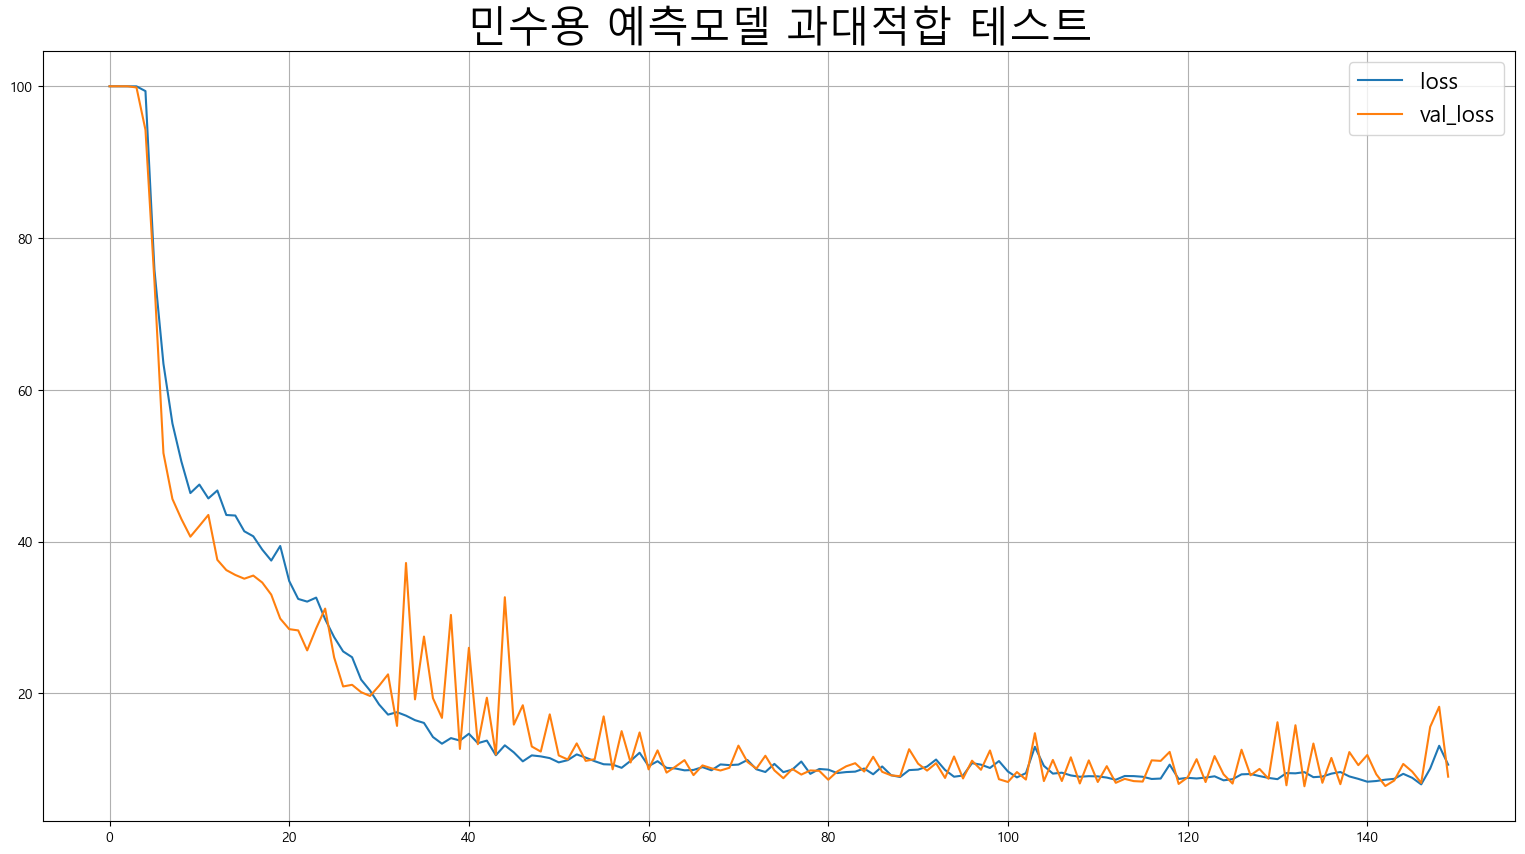

In [351]:
# LOSS, VAL_LOSS 비교
plt.figure(figsize=(19,10))
plt.title('민수용 예측모델 과대적합 테스트',fontsize=30)
plt.plot(history.history['loss'], label = 'loss ')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.grid()
plt.legend(fontsize=16)
plt.show()

### 3-1-4. 예측 (민수용) 

In [352]:
# 예측
pred_C = model_C.predict(x_val)
pred_C.shape

2/2 [==============================] - 0s 3ms/step


(36, 1)

In [353]:
date = pd.date_range('2018-1',periods=36,freq='MS')
len(date)

36

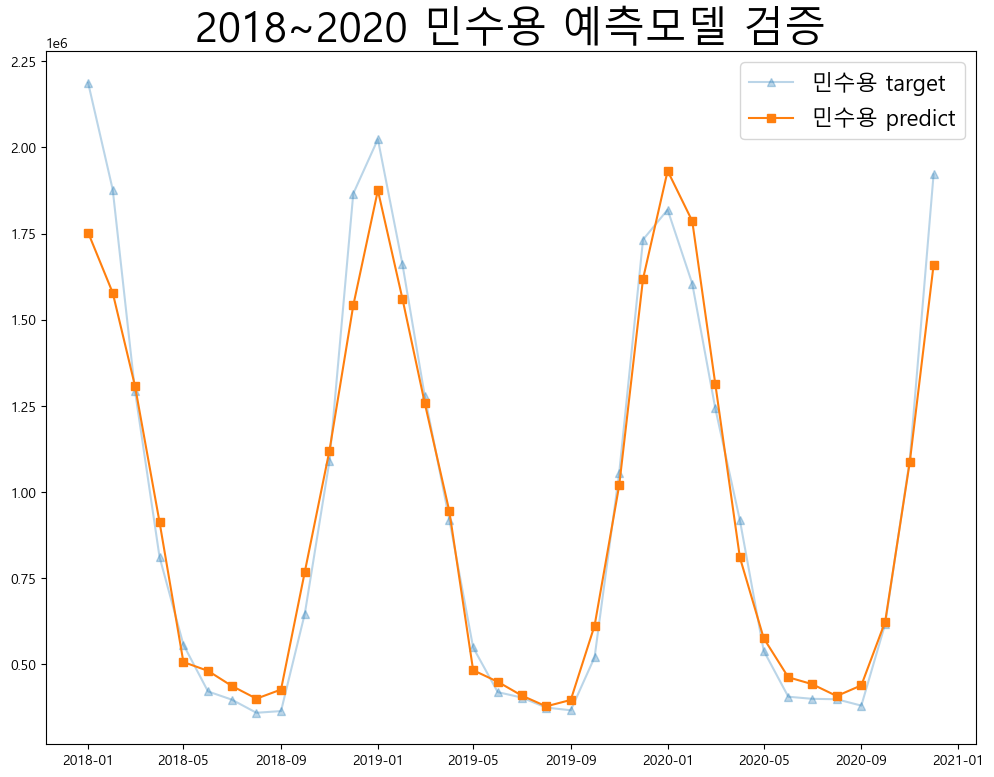

In [354]:
# 시각화
plt.figure(figsize=(12, 9))
plt.title('2018~2020 민수용 예측모델 검증',fontsize=30)
plt.plot(date, y_val_C,'^-', label = '민수용 target', alpha =0.3)
plt.plot(date, pred_C,'s-', label = '민수용 predict')
plt.legend(fontsize =16)
plt.show()

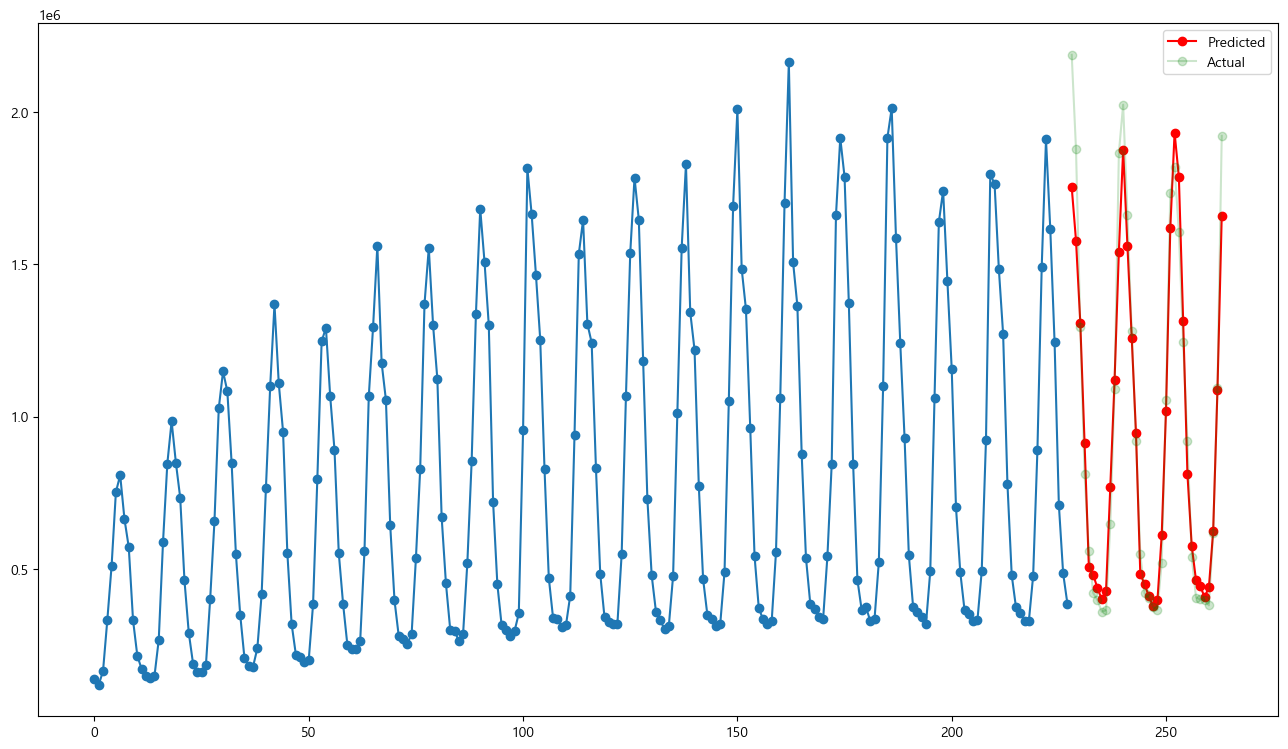

In [355]:
# [ 예측 결과 시각화: 전체흐름 파악용 ]
a_axis = np.arange(0, len(y_train_C))
b_axis = np.arange(len(y_train_C), len(y_train_C) + len(pred_C))

plt.figure(figsize=(16,9)) # .reshape(x_train.shape[0],) 
plt.plot(a_axis, y_train_C, 'o-') 
plt.plot(b_axis, pred_C, 'o-', color='red', label='Predicted')
plt.plot(b_axis, y_val_C, 'o-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()

## 3-2. 모형 학습_산업용
---
### 3-2-1. 과거 학습 단위 설정 (산업용)

In [469]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler_target = MinMaxScaler()
scale_cols = ['POWER_GAS','ELEC_INDSUM','OIL_PRICE','QVA','TCL_LT','TEMP_EF_MEAN','POWER_FIRE','ELEC_ALL']

# scale_cols = ['POWER_GAS','ELEC_INDSUM','OIL_PRICE','QVA','TEMP_EF_MEAN','ELEC_SERVICE','POWER_FIRE','ELEC_ALL']

# 스케일링
train_data_scaled = scaler.fit_transform(train_data[scale_cols])
test_data_scaled = scaler.fit_transform(test_data[scale_cols])
feature_all_scaled = scaler.fit_transform(feature_all[scale_cols])

train_target_scaled = scaler_target.fit_transform(train_target)

# 데이터프레임으로 변환
train_data_scaled = pd.DataFrame(train_data_scaled)
test_data_scaled = pd.DataFrame(test_data_scaled)
feature_all_scaled = pd.DataFrame(feature_all_scaled)
train_target_scaled = pd.DataFrame(train_target_scaled)

# 데이터프레임 컬럼명 생성
train_data_scaled.columns = scale_cols
test_data_scaled.columns = scale_cols
feature_all_scaled.columns = scale_cols

train_target_scaled.columns = ['CIVIL','IND']
train_target_scaled_C = train_target_scaled['CIVIL']
train_target_scaled_I = train_target_scaled['IND']


In [470]:
# train, val, test 범위 설정Z

TEST_SIZE = 50 # 테스트: 2015~2020(60개월) / 학습: 1996~2014(240개월)
WINDOW_SIZE = 14 # 학습시킬 과거 개월 단위(12개월)

# 학습 데이터 
x_train = train_data_scaled[:-TEST_SIZE] # 1996~2014
x_val = train_data_scaled[-TEST_SIZE:] # 2015~2020
x_test_final = test_data_scaled # 2021~2035(최종 목표)

# target 민수용(스케일 적용)
y_train_I = train_target_scaled_I[:-TEST_SIZE] # 1996~2014
y_val_I = train_target_scaled_I[-TEST_SIZE:] # 2015~2020

# target 민수용(스케일X)
y_train_I = train_target_I[:-TEST_SIZE] # 1996~2014
y_val_I = train_target_I[-TEST_SIZE:] # 2015~2020


# [ 최종 전용 (학습 300개월, 예측 180개월) ] 
# 학습 데이터
x_train = train_data_scaled #1996~2020
# target 민수용(스케일 X)
y_train_I = train_target_I # 1996~2020

In [471]:
x_test_final.shape

(180, 8)

In [472]:
# train, valid, test 과거학습 단위 생성

# 과거 12개월-> 다음 1개월 예측( 1996~2014년 )

# 산업용
x_train, y_train_I = make_dataset1(x_train, y_train_I, WINDOW_SIZE)
x_val, y_val_I = make_dataset1(x_val, y_val_I, WINDOW_SIZE)

# test용 (2021~2035년)
x_test_final = make_dataset2(x_test_final, WINDOW_SIZE)

In [473]:
print('[ 1996~2015 train/target 데이터 ]')
print(f'x_train.shape: {x_train.shape}, y_train_C.shape: {y_train_C.shape}, y_train_I.shape: {y_train_I.shape}') 
print()
print('[ 2016~2020 train/target 데이터 ]')
print(f'x_val.shape  : {x_val.shape},  y_train_C.shape: {y_val_C.shape}, y_train_I.shape: {y_val_I.shape}') 
print()
print('[ 2021~2035 train 데이터 ]')
print(f'x_test.shape : {x_test_final.shape}')
print() 

[ 1996~2015 train/target 데이터 ]
x_train.shape: (286, 14, 8), y_train_C.shape: (228,), y_train_I.shape: (286,)

[ 2016~2020 train/target 데이터 ]
x_val.shape  : (36, 14, 8),  y_train_C.shape: (36,), y_train_I.shape: (36,)

[ 2021~2035 train 데이터 ]
x_test.shape : (168, 12, 8)



### 3-2-2. 모델 구축 (산업용) 

In [488]:
# create LSTM model
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model_I = Sequential()
model_I.add(LSTM(32, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='relu', 
                return_sequences=False)
            )              

model_I.add(Dense(1))

In [489]:
# LSTM model compile

model_I.compile(loss='mape', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# import os
#model_path = 'model_I'
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model_I.fit(x_train, y_train_I, 
                                    epochs=500, 
                                    batch_size=16,
                                    validation_data=(x_val, y_val_I))
                                    # callbacks=[early_stop])

Epoch 1/500
18/18 [==============================] - 1s 15ms/step - loss: 99.9999 - val_loss: 99.9998
Epoch 2/500
18/18 [==============================] - 0s 5ms/step - loss: 99.9996 - val_loss: 99.9986
Epoch 3/500
18/18 [==============================] - 0s 5ms/step - loss: 99.9878 - val_loss: 99.8695
Epoch 4/500
18/18 [==============================] - 0s 5ms/step - loss: 98.5071 - val_loss: 88.1379
Epoch 5/500
18/18 [==============================] - 0s 5ms/step - loss: 59.2629 - val_loss: 44.8783
Epoch 6/500
18/18 [==============================] - 0s 5ms/step - loss: 28.0638 - val_loss: 23.7562
Epoch 7/500
18/18 [==============================] - 0s 5ms/step - loss: 21.7086 - val_loss: 26.4447
Epoch 8/500
18/18 [==============================] - 0s 5ms/step - loss: 20.9467 - val_loss: 28.2304
Epoch 9/500
18/18 [==============================] - 0s 5ms/step - loss: 20.6421 - val_loss: 31.8563
Epoch 10/500
18/18 [==============================] - 0s 5ms/step - loss: 18.4807 - val_lo

### 3-2-3. loss, val_loss 시각화 및 비교 (산업용) 

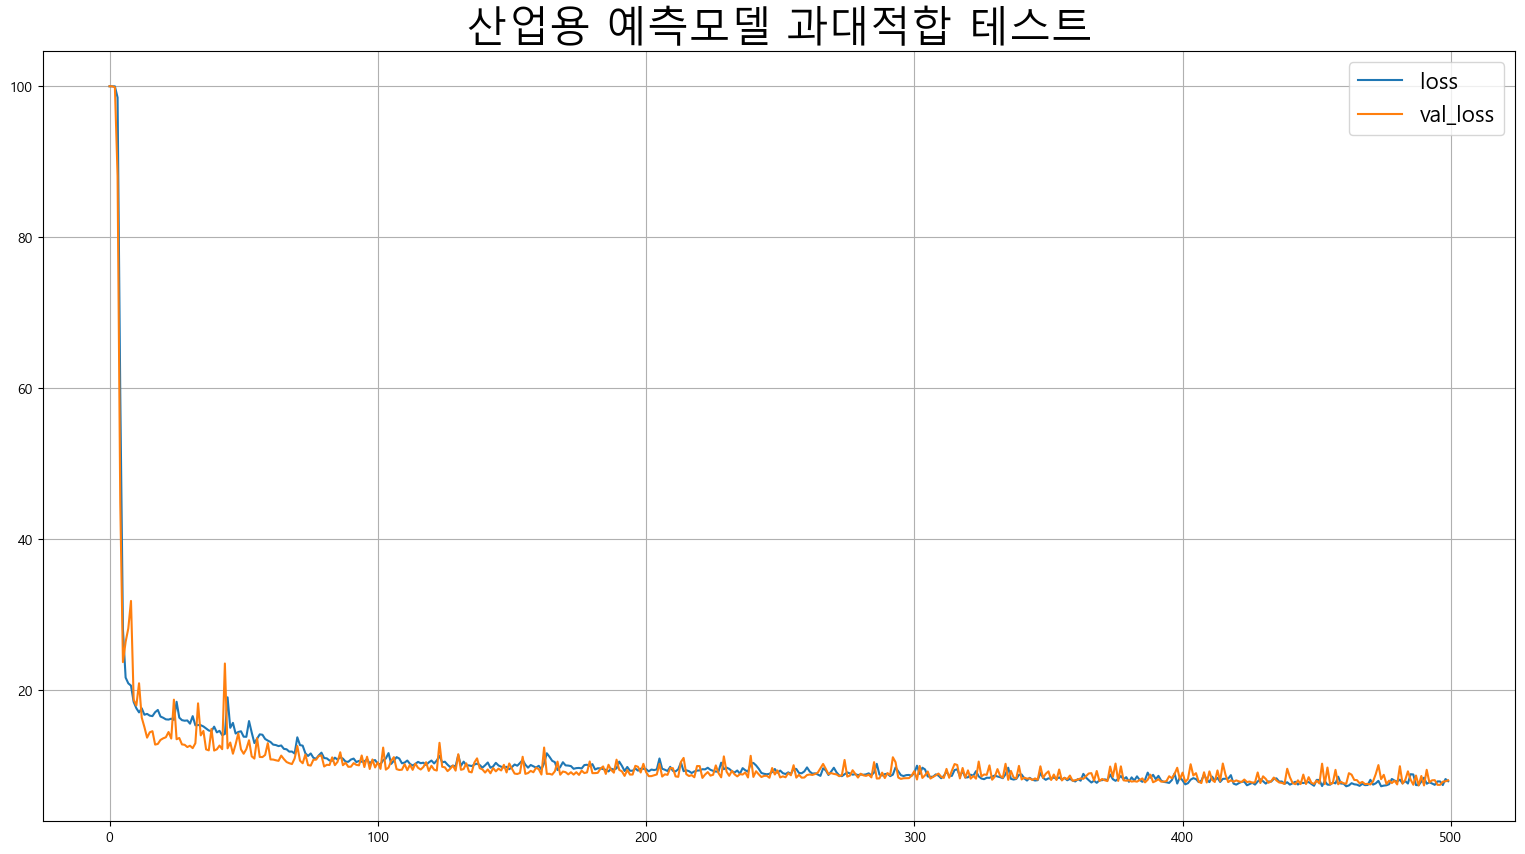

In [490]:
# LOSS, VAL_LOSS 비교
plt.figure(figsize=(19,10))
#plt.style.use(['default'])
plt.title('산업용 예측모델 과대적합 테스트',fontsize=30)
plt.plot(history.history['loss'], label = 'loss ')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(fontsize=16)
plt.grid()
plt.show()

### 3-2-4. 예측 (산업용) 

In [496]:
# 예측
pred_C = model_C.predict(x_val)
pred_C.shape

2/2 [==============================] - 0s 4ms/step


(36, 1)

In [497]:
# 예측
pred_I = model_I.predict(x_val)
pred_I.shape, y_val_I.shape

2/2 [==============================] - 0s 4ms/step


((36, 1), (36,))

In [498]:
# # 시각화
# plt.figure(figsize=(12, 9))
# plt.title('2018~2020 민수용 예측모델 검증',fontsize=30)
# plt.plot(date, y_val_C,'^-', label = '민수용 target', alpha =0.3)
# plt.plot(date, pred_C,'s-', label = '민수용 predict')
# plt.legend(fontsize =16)
# plt.show()

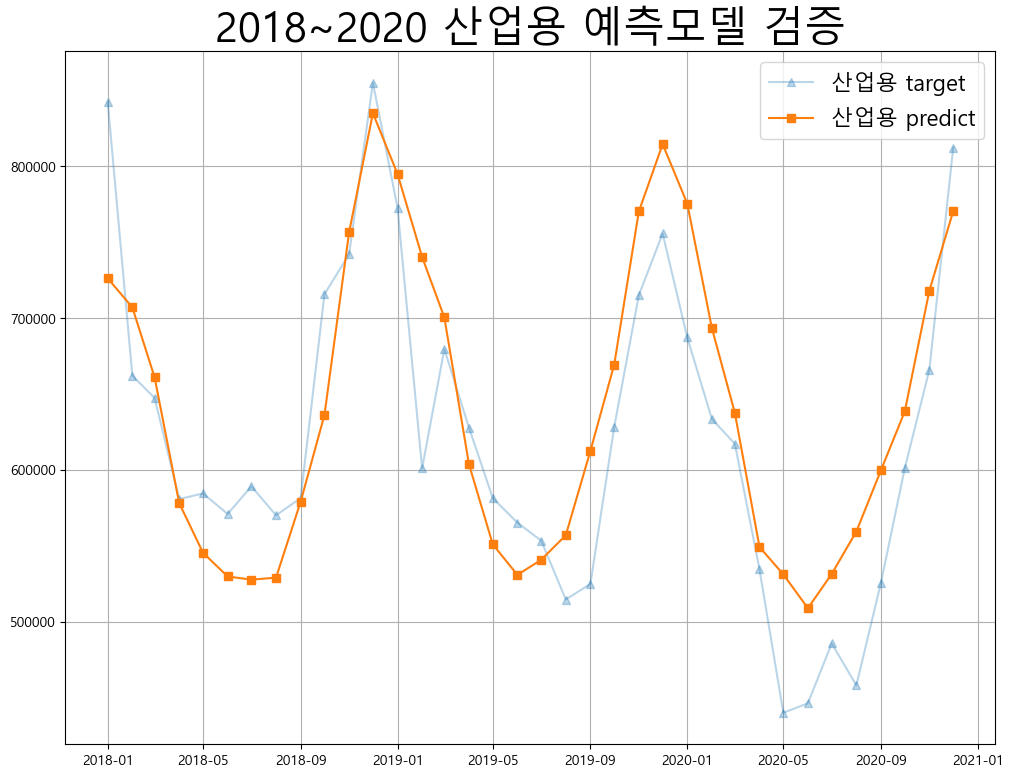

In [499]:
# 시각화
plt.figure(figsize=(12, 9))
plt.title('2018~2020 산업용 예측모델 검증',fontsize=30)
plt.plot(date,y_val_I,'^-', label = '산업용 target',alpha=0.3)
plt.plot(date,pred_I,'s-', label = '산업용 predict')
plt.grid()
plt.legend(fontsize=16)
plt.show()

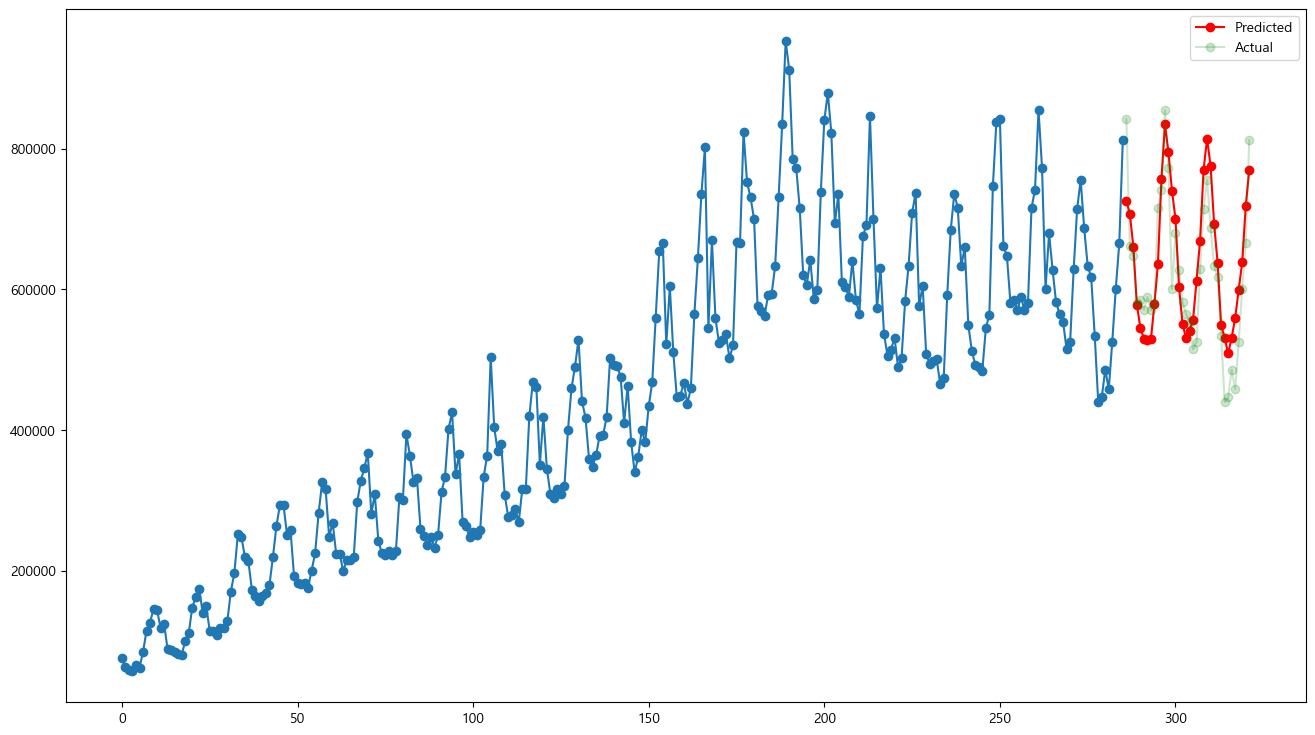

In [500]:
# [ 예측 결과 시각화: 전체흐름 파악용 ]
a_axis = np.arange(0, len(y_train_I))
b_axis = np.arange(len(y_train_I), len(y_train_I) + len(pred_I))

plt.figure(figsize=(16,9)) # .reshape(x_train.shape[0],) 
plt.plot(a_axis, y_train_I, 'o-') 
plt.plot(b_axis, pred_I, 'o-', color='red', label='Predicted')
plt.plot(b_axis, y_val_I, 'o-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()